In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import math
%matplotlib inline

# Formula for Enthalpy Change (ΔH)

The enthalpy change is calculated using the formula:

$$
\Delta H = E(\text{alloy}) - \sum E(\text{pure elements})
$$

## Explanation

1. **E(alloy)**:
   - Represents the total energy of the alloy.
   - This value is typically negative.

2. **∑E(pure elements)**:
   - Represents the sum of the energies of the pure elements.
   - These values are also negative and stored in the `H_purSince both **E(alloy)** and **∑E(pure elements)** are negative, the subtraction reflects the relative stability of the alloy compared to its constituent pure elements.ent pure elements.
nt pure elements.


In [2]:
df = pd.read_excel('all_data_combined_ml_dos_enthaly_structure.xlsx')
df.head()

,Alloy,N(Ef),DH (eV),Structure
0,Cr50Mo50,0.6514,3.483522,BCC
1,Cr50Nb50,0.9385,4.869896,BCC
2,Cr50Ta50,0.9722,3.352884,BCC
3,Cr50Ti50,1.4112,0.734815,BCC
4,Cr50V50,1.2213,-2.022501,BCC


In [3]:
import pandas as pd

# Assuming `df` is your DataFrame and 'Alloy' is the column of interest
duplicate_alloys = df[df['Alloy'].duplicated(keep=False)]

# Print duplicate alloy names
print("Number of duplicate alloy names:", duplicate_alloys.shape[0])
print("\nDuplicate alloy names:")
print(duplicate_alloys)

Number of duplicate alloy names: 0

Duplicate alloy names:
Empty DataFrame
Columns: [Alloy, N(Ef), DH (eV), Structure]
Index: []


### **Mixing Enthalpy**
- The mixing enthalpy is calculated using the following formula:
  $$
  \Delta H_{\text{mix}} = \sum_{i=1, i \neq j}^{n} 4H_{ij}C_iC_j
  $$
  where:
  - $C_i, C_j$: Molar percentages of elements $i$ and $j$.
  - $H_{ij}$: Interaction parameter (enthalpy of mixing) for the element pair $i$ and $j$.

- Iterates through all unique pairs of elements and calculates the contribution to the total enthalpy of mixing.

# Atomic Size Difference (δ)

The atomic size difference (δ) is calculated using the following formula:

$$
\delta = \sum_{i=1}^{n} C_i \left( 1 - \frac{r_i}{\bar{r}} \right)^2
$$

where:

- $C_i$ is the atomic percentage of element $i$,
- $r_i$ is the atomic radius of element $i$,
- $\bar{r}$ is the average atomic radius of the alloy.
 the alloy.
 the alloy.
 the alloy.


In [4]:
import re
import math
import pandas as pd

# Define the mixing enthalpy values for AB pairs
AB_mix_enthalpy = {
    'Cr-Mo': 0, 'Cr-W': 1, 'Cr-V': -2, 'Cr-Nb': -7, 'Cr-Ta': -7, 'Cr-Ti': -7,
    'Cr-Zr': -12, 'Cr-Hf': -9, 'Mo-W': 0, 'Mo-V': 0, 'Mo-Nb': -6, 'Mo-Ta': -5,
    'Mo-Ti': -4, 'Mo-Zr': -6, 'Mo-Hf': -4, 'W-V': -1, 'W-Nb': -8, 'W-Ta': -7,
    'W-Ti': -6, 'W-Zr': -9, 'W-Hf': -6, 'V-Nb': -1, 'V-Ta': -1, 'V-Ti': -2,
    'V-Zr': -4, 'V-Hf': -2, 'Nb-Ta': 0, 'Nb-Ti': 2, 'Nb-Zr': 4, 'Nb-Hf': 4,
    'Ta-Ti': 1, 'Ta-Zr': 3, 'Ta-Hf': 3, 'Ti-Zr': 0, 'Ti-Hf': 0, 'Zr-Hf': 0
}

# Elements list
elements = ['Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf']

# Function to parse the composition when atomic percentages are given

def parse_atomic_percentages(composition):
    """
    Parses the composition to extract elements and their atomic percentages.

    Args:
        composition (str): Alloy composition in the format "Ti33Cr33Hf34".

    Returns:
        dict: Dictionary with elements as keys and their atomic percentages as values.

    Raises:
        ValueError: If the total atomic percentage is outside the range [99%, 101%].
    """
    # Extract elements and percentages using regex
    matches = re.findall(r'([A-Z][a-z]*)(\d*\.?\d+|\d+)', composition)
    elements = [element for element, _ in matches]
    percentages = [float(percentage) for _, percentage in matches]

    # Calculate total sum of percentages
    total_percentage = sum(percentages)

    # Check if total percentage is outside the range [99%, 101%]
    if not (99 <= total_percentage <= 101):
        raise ValueError(
            f"The total atomic percentage for {composition} is {total_percentage}%, "
            "which is outside the allowed range [99%, 101%]."
        )

    # Adjust percentages to sum to 100% if the total is not exactly 100%
    if abs(total_percentage - 100) > 1e-6:
        scaling_factor = 100 / total_percentage
        percentages = [p * scaling_factor for p in percentages]

    return dict(zip(elements, percentages))

# Function to calculate mixing enthalpy using atomic percentages
def calculate_mixing_enthalpy(composition, enthalpy_dict):
    """
    Calculate the mixing enthalpy for a composition using atomic percentages.

    Args:
        composition (str): Alloy composition in the format "Ta20Nb20Hf20Zr20Ti20".
        enthalpy_dict (dict): Mixing enthalpy values for AB pairs.

    Returns:
        float: Calculated mixing enthalpy.
    """
    percentages = parse_atomic_percentages(composition)
    elements = list(percentages.keys())
    n = len(elements)
    total_enthalpy = 0

    # Iterate over all pairs of elements
    for i in range(n):
        for j in range(i + 1, n):
            pair = f"{elements[i]}-{elements[j]}"
            reverse_pair = f"{elements[j]}-{elements[i]}"
            interaction = enthalpy_dict.get(pair, enthalpy_dict.get(reverse_pair, 0))
            # Include the factor of 4 as per the formula
            total_enthalpy += 4 * (percentages[elements[i]] / 100) * (percentages[elements[j]] / 100) * interaction

    return total_enthalpy

# Function to calculate VEC
def calculate_vec(composition, pvec):
    """
    Calculate VEC when atomic percentages are directly given in the composition.

    Args:
        composition (str): The alloy composition in the format "Ti33Cr33Hf34".
        pvec (dict): A dictionary of valence electron concentrations for each element.

    Returns:
        float: The calculated VEC.
    """
    percentages = parse_atomic_percentages(composition)
    vec_sum = sum(percentage * pvec.get(element, 0) for element, percentage in percentages.items())
    vec_sum /= 100  # Divide by 100 to get the correct VEC

    return vec_sum

# Define the pvec values for elements
pvec = {'Cr': 6, 'Mo': 6, 'W': 6, 'V': 5, 'Nb': 5, 'Ta': 5, 'Ti': 4, 'Hf': 4, 'Zr': 4}

# Function to calculate melting temperature (MT)
def calculate_mt(composition, mt):
    """
    Calculate melting temperature (MT) when atomic percentages are given.

    Args:
        composition (str): Alloy composition in the format "Ti33Cr33Hf34".
        mt (dict): Dictionary of melting temperatures for each element.

    Returns:
        float: Calculated melting temperature (MT).
    """
    percentages = parse_atomic_percentages(composition)
    mt_sum = sum(percentage * mt.get(element, 0) for element, percentage in percentages.items())
    mt_sum /= 100  # Divide by 100 to get the weighted average MT

    return mt_sum

# Define the mt values for elements
mt = {'Cr': 1907, 'Mo': 2623, 'W': 3422, 'V': 1910, 'Nb': 2477, 'Ta': 3017, 'Ti': 1668, 'Zr': 1852, 'Hf': 2233}

# Function to calculate the weighted average Pauling electronegativity
def calculate_pauli(composition, chi):
    """
    Calculate the weighted average Pauling electronegativity for a composition using atomic percentages.

    Args:
        composition (str): Chemical composition string (e.g., "Ti33Cr33Hf34").
        chi (dict): Dictionary of Pauling electronegativity values for each element.

    Returns:
        float: Weighted average Pauling electronegativity.
    """
    percentages = parse_atomic_percentages(composition)
    pauli_sum = sum(percentage * chi.get(element, 0) for element, percentage in percentages.items())
    pauli_sum /= 100  # Divide by 100 to get the weighted average

    return pauli_sum

# Define the chi values for elements
chi = {'Cr': 1.66, 'Mo': 2.16, 'W': 2.36, 'V': 1.63, 'Nb': 1.6, 'Ta': 1.5, 'Ti': 1.54, 'Zr': 1.33, 'Hf': 1.3}

# Function to calculate the entropy of mixing
def calculate_entropy_of_mixing(composition):
    """
    Calculate the entropy of mixing (ΔSmix) using atomic percentages.

    Args:
        composition (str): Chemical composition string (e.g., "Ti33Cr33Hf34").

    Returns:
        float: Entropy of mixing (ΔSmix) in J/(mol·K).
    """
    percentages = parse_atomic_percentages(composition)
    molar_fractions = [percentage / 100 for percentage in percentages.values()]

    # Calculate entropy of mixing (ΔSmix)
    R = 8.314  # Gas constant in J/(mol·K)
    smix = -R * sum(mf * math.log(mf) for mf in molar_fractions if mf > 0)

    return smix

# Dictionary of metallic radii
metallic_radius = {'Cr': 1.28,'Mo': 1.39, 'W': 1.39, 'V': 1.34, 'Nb': 1.46, 'Ta': 1.46, 'Ti': 1.47, 'Zr': 1.60, 'Hf': 1.59 }

# Function to calculate atomic size difference (δ)
def calculate_atomic_size_difference(composition, metallic_radius):
    """
    Calculates the atomic size difference (δ) of an alloy.

    Args:
        composition (str): Alloy composition in the format "Ti33Cr33Hf34".
        metallic_radius (dict): Dictionary of metallic radii for elements.

    Returns:
        float: Atomic size difference (δ).
    """
    # Parse the composition to get atomic percentages
    atomic_percentages = parse_atomic_percentages(composition)

    # Calculate the average atomic radius (r̄)
    total_percentage = sum(atomic_percentages.values())
    average_radius = sum(atomic_percentages[element] * metallic_radius.get(element, 0) for element in atomic_percentages) / total_percentage

    # Calculate the atomic size difference (δ)
    delta_squared = sum(
        atomic_percentages[element] * (1 - (metallic_radius.get(element, 0) / average_radius)) ** 2
        for element in atomic_percentages
    )
    delta = math.sqrt(delta_squared)

    return delta


# Function to extract element percentages from atomic percentage composition
def calculate_element_percentages(alloy):
    """
    Extracts the atomic percentages for each element from the composition.

    Args:
        alloy (str): Alloy composition string (e.g., "Ti33Cr33Hf34").

    Returns:
        dict: Dictionary with element percentages.
    """
    # Use the parse_atomic_percentages function to get the percentages
    percentages = parse_atomic_percentages(alloy)
    
    # Ensure all elements in the predefined list are included, even if their percentage is 0
    for element in elements:
        if element not in percentages:
            percentages[element] = 0.0

    return percentages




In [5]:
## TEST
composition = 'W20Nb20Mo20Ta20V20'

# Calculate mixing enthalpy
mixing_enthalpy = calculate_mixing_enthalpy(composition, AB_mix_enthalpy)
print(f"Mixing Enthalpy: {mixing_enthalpy} kJ/mol")

Mixing Enthalpy: -4.640000000000001 kJ/mol


In [6]:
## TEST
composition = "Ta20Nb20Hf20Zr20Ti20"
delta = calculate_atomic_size_difference(composition, metallic_radius)
print(f"Atomic size difference (δ) for {composition}: {delta:.4f}")

Atomic size difference (δ) for Ta20Nb20Hf20Zr20Ti20: 0.4267


In [7]:
df.head()

,Alloy,N(Ef),DH (eV),Structure
0,Cr50Mo50,0.6514,3.483522,BCC
1,Cr50Nb50,0.9385,4.869896,BCC
2,Cr50Ta50,0.9722,3.352884,BCC
3,Cr50Ti50,1.4112,0.734815,BCC
4,Cr50V50,1.2213,-2.022501,BCC


In [8]:
# Mixing enthalpy
df['Mixing Enthalpy'] = df['Alloy'].apply(lambda x: calculate_mixing_enthalpy(x, AB_mix_enthalpy))

# VEC
df['VEC'] = df['Alloy'].apply(lambda x: calculate_vec(x, pvec))

# Melting temperature
df['Melting Temperature'] = df['Alloy'].apply(lambda x: calculate_mt(x, mt))

# Electronegativity
df['Pauling Electronegativity'] = df['Alloy'].apply(lambda x: calculate_pauli(x, chi))

# Entropy of mixing
df['Entropy of Mixing'] = df['Alloy'].apply(calculate_entropy_of_mixing)

df['Radii Difference'] =df['Alloy'].apply(lambda x: calculate_atomic_size_difference(x, metallic_radius))

# Apply the function and expand the result into new columns
percentages_df = df['Alloy'].apply(lambda x: calculate_element_percentages(x)).apply(pd.Series)
df = pd.concat([df, percentages_df], axis=1)

In [9]:
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,Cr50Mo50,0.6514,3.483522,BCC,0.0,6.0,2265.0,1.910,5.762826,0.411985,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cr50Nb50,0.9385,4.869896,BCC,-7.0,5.5,2192.0,1.630,5.762826,0.656934,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
2,Cr50Ta50,0.9722,3.352884,BCC,-7.0,5.5,2462.0,1.580,5.762826,0.656934,50.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
3,Cr50Ti50,1.4112,0.734815,BCC,-7.0,5.0,1787.5,1.600,5.762826,0.690909,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
4,Cr50V50,1.2213,-2.022501,BCC,-2.0,5.5,1908.5,1.645,5.762826,0.229008,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0


In [10]:
dos = {
    'Cr': 0.6025, 'Mo': 0.5585, 'W': 0.4296, 'V': 1.9971, 'Nb': 1.8519, 
    'Ta': 1.5178, 'Ti': 1.9422, 'Zr': 1.7116, 'Hf': 1.875
}

# Function to calculate the ROM DOS
def calculate_ROM_DOS(composition, dos):
    """
    Calculate the ROM DOS (Rule of Mixtures Density of States) for the alloy.

    Args:
        composition (str): The alloy composition in the format "Ti33Cr33Hf34".
        dos (dict): A dictionary of DOS values for each element.

    Returns:
        float: The calculated ROM DOS.
    """
    # Use the parse_atomic_percentages function to get the percentages
    percentages = parse_atomic_percentages(composition)

    # Calculate ROM DOS
    rom_dos_sum = sum(percentage * dos.get(element, 0) for element, percentage in percentages.items())
    rom_dos_sum /= 100  # Divide by 100 to get the correct ROM DOS

    return rom_dos_sum

# Calculate ROM DOS for each alloy
df['ROM_DOS'] = df['Alloy'].apply(lambda x: calculate_ROM_DOS(x, dos))



In [11]:
df.columns

Index(['Alloy', 'N(Ef)', 'DH (eV)', 'Structure', 'Mixing Enthalpy', 'VEC',
       'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing',
       'Radii Difference', 'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf',
       'ROM_DOS'],
      dtype='object')

In [12]:
df= df[df['Structure']=='BCC']

df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf,ROM_DOS
0,Cr50Mo50,0.6514,3.483522,BCC,0.0,6.0,2265.0,1.910,5.762826,0.411985,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58050
1,Cr50Nb50,0.9385,4.869896,BCC,-7.0,5.5,2192.0,1.630,5.762826,0.656934,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,1.22720
2,Cr50Ta50,0.9722,3.352884,BCC,-7.0,5.5,2462.0,1.580,5.762826,0.656934,50.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,1.06015
3,Cr50Ti50,1.4112,0.734815,BCC,-7.0,5.0,1787.5,1.600,5.762826,0.690909,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.27235
4,Cr50V50,1.2213,-2.022501,BCC,-2.0,5.5,1908.5,1.645,5.762826,0.229008,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,1.29980


In [13]:
df.to_csv('Final_df_all_bcc.csv', index=False)
df= pd.read_csv('Final_df_all_bcc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Alloy                      417 non-null    object 
 1   N(Ef)                      417 non-null    float64
 2   DH (eV)                    417 non-null    float64
 3   Structure                  417 non-null    object 
 4   Mixing Enthalpy            417 non-null    float64
 5   VEC                        417 non-null    float64
 6   Melting Temperature        417 non-null    float64
 7   Pauling Electronegativity  417 non-null    float64
 8   Entropy of Mixing          417 non-null    float64
 9   Radii Difference           417 non-null    float64
 10  Cr                         417 non-null    float64
 11  Mo                         417 non-null    float64
 12  W                          417 non-null    float64
 13  V                          417 non-null    float64

In [14]:
feature_columns =['Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing',
                  'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf' ] 

X=df[feature_columns]
y=df['N(Ef)']

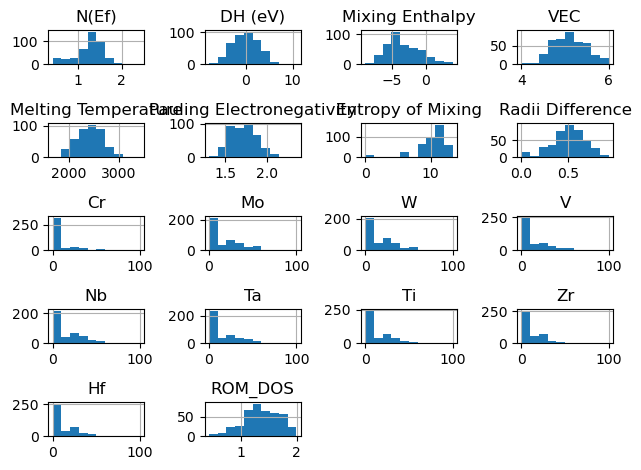

In [15]:
df.hist()
plt.tight_layout()
plt.show()

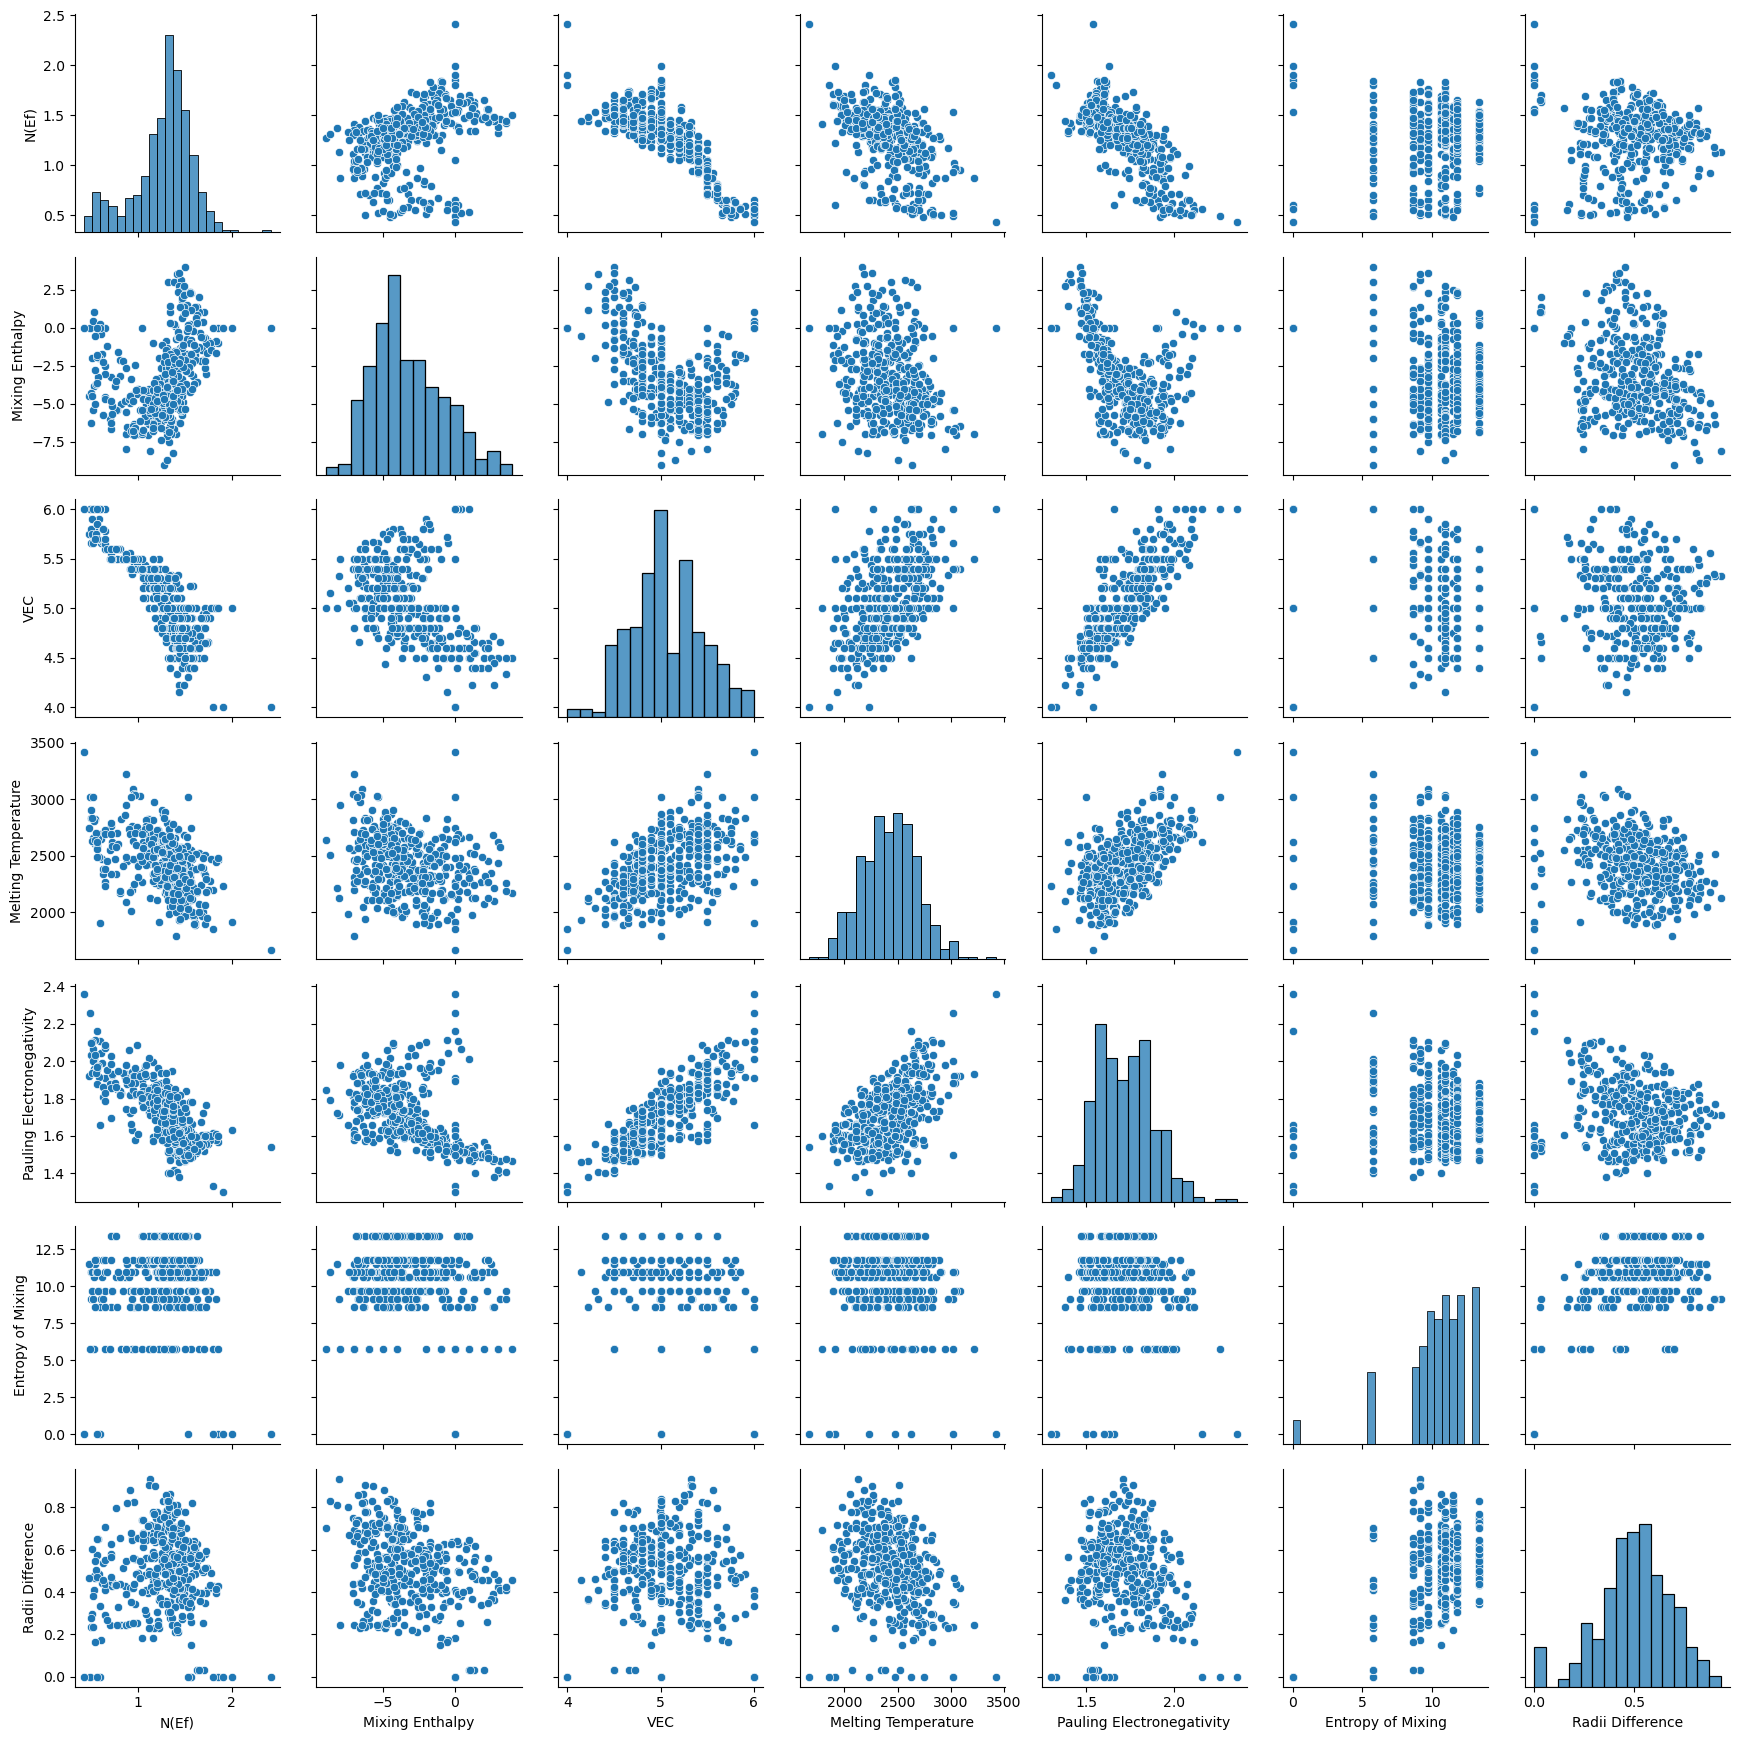

In [16]:
# plt.figure(figsize=(8,8))
sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']])  # Creates scatter plots for all pairs of features
plt.tight_layout()
plt.show()

In [17]:
# sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing']], hue='N(Ef)')  # Replace 'target_column' with the name of your categorical column
# plt.tight_layout()
# plt.show()

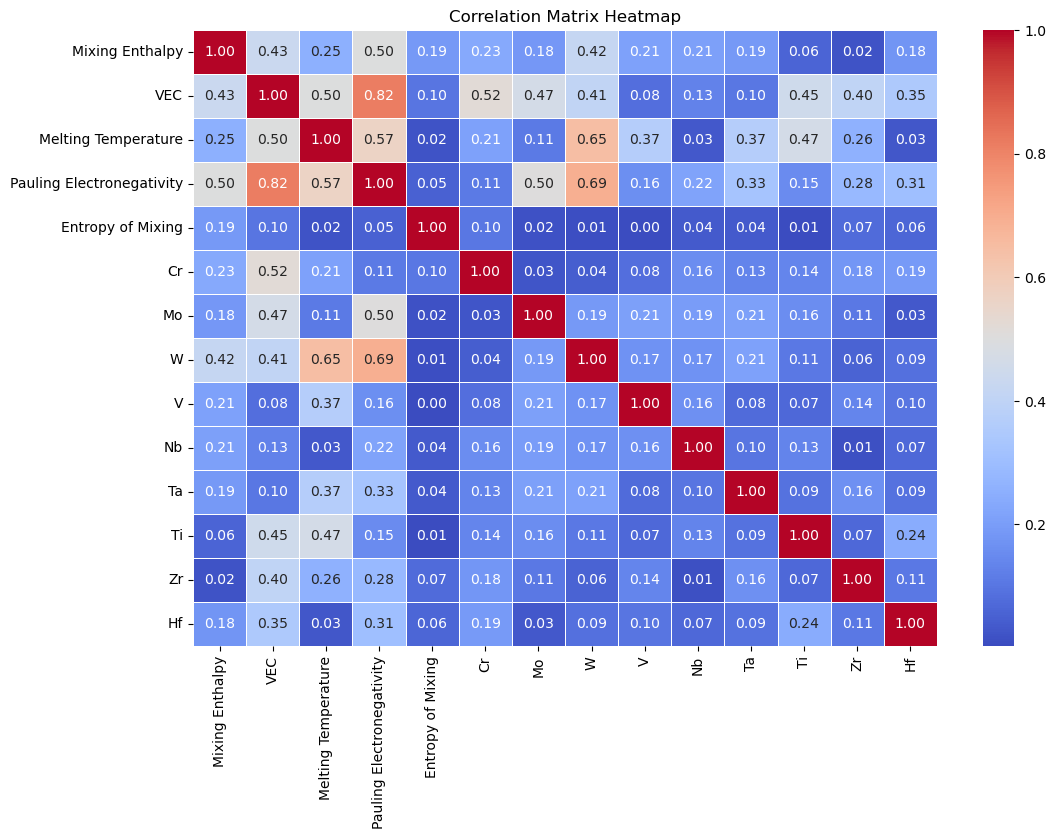

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(X.corr().abs(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()
          

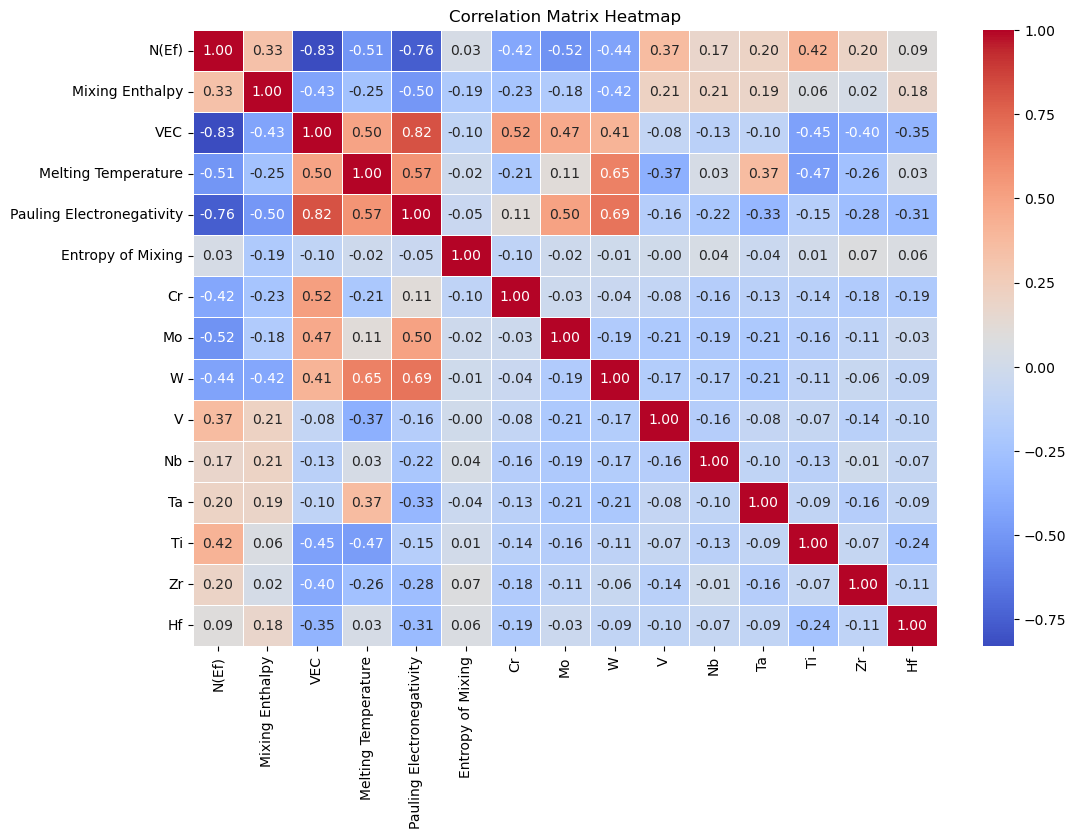

In [19]:
all_feature =['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing',
                  'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf' ]

plt.figure(figsize=(12,8))
sns.heatmap(df[all_feature].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:

# Define the Young’s modulus (E_VRH) dictionary
evrh = {
    "Cr": 279, "Mo": 329, "W": 382, "V": 130, "Nb": 105, "Ta": 186, 
    "Ti": 116, "Hf": 78, "Zr": 88, "Re": 450, "Ru": 480
}


def calculate_weighted_evrh(composition, evrh):
    """
    Calculate the weighted average Young’s modulus (E_VRH) for the alloy.

    Args:
        composition (str): The alloy composition.
        evrh (dict): A dictionary of E_VRH values for each element.

    Returns:
        float: Weighted average Young’s modulus (E_VRH).
    """
    percentages = parse_atomic_percentages(composition)

    # Compute weighted Young’s modulus
    evrh_sum = sum(percentage * evrh.get(element, 0) for element, percentage in percentages.items())
    return evrh_sum / 100  # Normalize by 100

# Calculate only E_VRH for each alloy
df['Avg E'] = df['Alloy'].apply(lambda x: calculate_weighted_evrh(x, evrh))
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,...,Mo,W,V,Nb,Ta,Ti,Zr,Hf,ROM_DOS,Avg E
0,Cr50Mo50,0.6514,3.483522,BCC,0.0,6.0,2265.0,1.910,5.762826,0.411985,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58050,304.0
1,Cr50Nb50,0.9385,4.869896,BCC,-7.0,5.5,2192.0,1.630,5.762826,0.656934,...,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,1.22720,192.0
2,Cr50Ta50,0.9722,3.352884,BCC,-7.0,5.5,2462.0,1.580,5.762826,0.656934,...,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,1.06015,232.5
3,Cr50Ti50,1.4112,0.734815,BCC,-7.0,5.0,1787.5,1.600,5.762826,0.690909,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.27235,197.5
4,Cr50V50,1.2213,-2.022501,BCC,-2.0,5.5,1908.5,1.645,5.762826,0.229008,...,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,1.29980,204.5


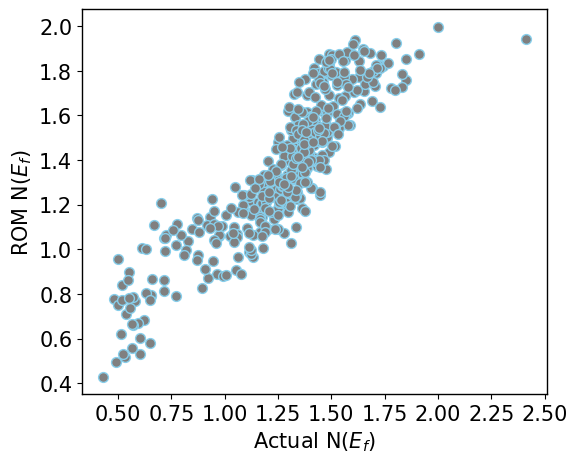

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df.ROM_DOS, marker='o', c= 'grey', s=50, edgecolor='skyblue')
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel(r'ROM N($E_f$)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)

plt.show()


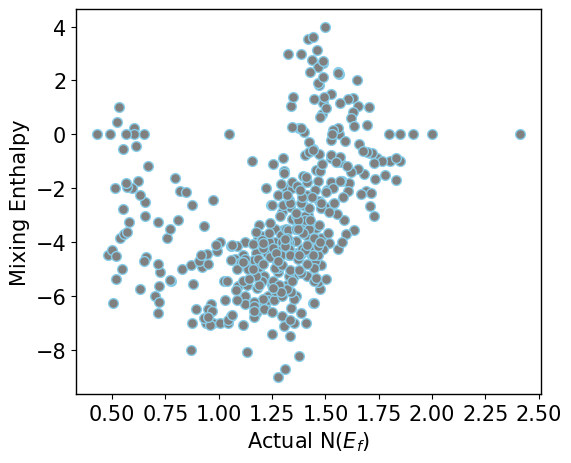

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['Mixing Enthalpy'], marker='o', c= 'grey', s=50, edgecolor='skyblue')
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel('Mixing Enthalpy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)

plt.show()


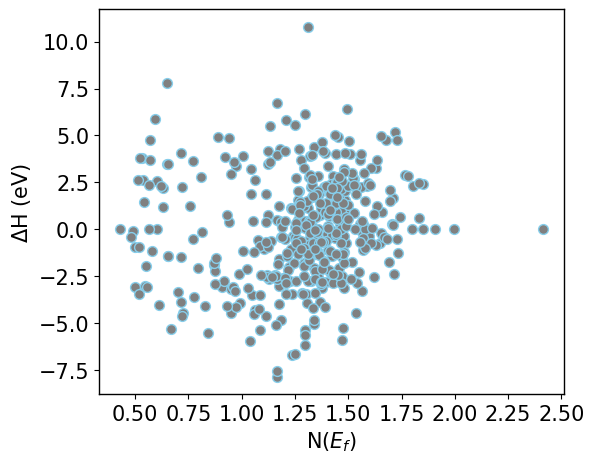

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['DH (eV)'], marker='o', c= 'grey', s=50, edgecolor='skyblue')
plt.xlabel('N($E_f$)', fontsize=fs)
plt.ylabel('$\Delta$H (eV)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)

plt.show()


In [24]:
# df= df[df['Structure']=='BCC']

# df.head()


# Train-Test Split

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [27]:
x_train.head(2)

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
345,-3.04,5.0,2611.8,1.678,13.380867,0.0,0.0,20.0,20.0,20.0,20.0,0.0,0.0,20.0
309,-5.44,5.2,2678.2,1.790,13.380867,0.0,20.0,20.0,0.0,20.0,20.0,0.0,20.0,0.0


In [28]:
# Normalize
scaler = StandardScaler()

# fit the scaler to training data

scaler.fit(x_train)

# Save the scaler to a file
joblib.dump(scaler, 'DOS_scaler.pkl')  # Saves the scaler to 'scaler.pkl'

#transform training data
X_train = scaler.transform(x_train)

#transform test data

X_test = scaler.transform(x_test)

# Convert back to DataFrame with original feature names
X_train = pd.DataFrame(X_train, columns=x_train.columns)
X_test = pd.DataFrame(X_test, columns=x_test.columns)
X_train

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,0.053068,-0.136436,0.692884,-0.267652,1.211417,-0.461096,-0.839453,0.382371,0.565048,0.440864,0.471455,-0.739425,-0.681928,0.812853
1,-0.915312,0.374049,0.942220,0.404271,1.211417,-0.461096,0.319974,0.382371,-0.709756,0.440864,0.471455,-0.739425,0.896126,-0.675626
2,-0.334284,-0.136436,-0.217905,0.359276,0.471071,-0.461096,-0.839453,0.685825,0.883749,0.759042,-0.752673,0.888639,-0.681928,-0.675626
3,-0.786194,-0.136436,0.478095,0.272286,0.117923,-0.461096,-0.839453,0.989280,-0.709756,1.713578,-0.752673,-0.088199,0.896126,-0.675626
4,0.504979,-0.136436,0.092826,-0.507625,1.211417,-0.461096,0.319974,-0.831447,0.565048,0.440864,0.471455,-0.739425,-0.681928,0.812853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,-0.140608,1.395017,0.557702,0.836221,1.211417,1.016719,0.319974,0.382371,0.565048,-0.831851,0.471455,-0.739425,-0.681928,-0.675626
329,-0.233411,0.501670,-1.503073,0.149300,0.471071,1.386173,0.609831,-0.831447,0.883749,-0.831851,-0.752673,0.888639,-0.681928,-0.675626
330,-1.141267,1.139775,0.460822,0.944209,-1.828656,-0.461096,2.059115,-0.831447,-0.709756,2.349935,-0.752673,-0.739425,-0.681928,-0.675626
331,0.472699,-1.923131,-1.478665,-1.005567,-0.252250,-0.461096,-0.839453,-0.224538,-0.709756,-0.831851,-0.140609,2.516703,1.685154,-0.675626


In [29]:
x_test

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
286,-1.70,5.00,2446.0,1.6120,10.958644,0.0,0.0,5.0,40.0,15.0,35.0,5.0,0.0,0.0
282,-1.37,4.80,2645.5,1.5635,10.958644,0.0,15.0,5.0,0.0,0.0,40.0,0.0,5.0,35.0
370,-5.44,5.40,2693.4,1.8040,11.793273,10.0,30.0,10.0,0.0,0.0,40.0,10.0,0.0,0.0
177,-3.75,4.75,2496.0,1.6475,11.525651,0.0,0.0,25.0,0.0,25.0,0.0,0.0,25.0,25.0
185,-5.50,4.75,2213.0,1.7150,11.525651,0.0,0.0,25.0,25.0,0.0,0.0,25.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-1.32,4.50,2284.9,1.5680,10.640708,0.0,0.0,10.0,0.0,0.0,30.0,40.0,20.0,0.0
13,0.00,5.00,2747.0,1.5500,5.762826,0.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0
362,-4.48,4.90,2169.8,1.7100,11.793273,10.0,30.0,0.0,0.0,0.0,10.0,40.0,0.0,10.0
129,-0.64,4.90,2738.7,1.5760,10.640708,0.0,0.0,10.0,0.0,30.0,40.0,0.0,0.0,20.0


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

#Make scorrer
score_rmse =make_scorer(root_mean_squared_error, greater_is_better=False)
score_mae =make_scorer(mean_absolute_error, greater_is_better=False)

# Define Kfold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## Models Training

In [31]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),  # Default 5 neighbors
    'SVR': SVR(C=100, gamma=0.001, kernel='rbf'),
    'Decision Tree': DecisionTreeRegressor(criterion='squared_error', min_samples_split= 5, splitter= 'best', random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)

}


# Define scoring metrics for cross-validation
scoring_metrics = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(root_mean_squared_error, greater_is_better=False)
}

# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for each model
models_results = []
for name, model in models.items():
    results = {}
    results['Model'] = name
    
    # Perform cross-validation for each metric
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
        results[f'Mean {metric_name.upper()}'] = np.mean(scores)
        results[f'STD {metric_name.upper()}'] = np.std(scores)
    
    models_results.append(results)

# Convert results to DataFrame and display
results_df = pd.DataFrame(models_results)
# Save DataFrame
results_df.to_csv('model_comparision.csv', index=False)
print(results_df)


               Model   Mean R2    STD R2  Mean MAE   STD MAE  Mean RMSE  \
0  Linear Regression  0.839721  0.056508 -0.089215  0.010795  -0.116596   
1      KNN Regressor  0.832942  0.070565 -0.081447  0.012642  -0.119683   
2                SVR  0.898087  0.019646 -0.070623  0.006851  -0.095467   
3      Decision Tree  0.873633  0.092657 -0.072977  0.011429  -0.099680   
4      Random Forest  0.931912  0.052487 -0.050835  0.007986  -0.072954   
5  Gradient Boosting  0.936699  0.050363 -0.049195  0.008306  -0.070142   
6            XGBoost  0.911379  0.097596 -0.054094  0.013478  -0.078359   

   STD RMSE  
0  0.011633  
1  0.025254  
2  0.015800  
3  0.020532  
4  0.023658  
5  0.023137  
6  0.028186  


# Grid Search for Random forest, GB and XGB

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np



# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [10, 20, 50,100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0]
    }
}

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Fine-tuning each model
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    param_grid = param_grids[model_name]
    
    # Use GridSearchCV for exhaustive search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Save the best model and its parameters
    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Display results
for model_name, result in best_models.items():
    print(f"\nBest results for {model_name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best CV R² Score: {result['best_score']}")


Tuning Random Forest...
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Tuning Gradient Boosting...
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


C:\Users\dpant\AppData\Local\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuning XGBoost...
Fitting 10 folds for each of 270 candidates, totalling 2700 fits

Best results for Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best CV R² Score: 0.9347270333644995

Best results for Gradient Boosting:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Best CV R² Score: 0.9541724901034065

Best results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
Best CV R² Score: 0.9370139864812671


In [33]:
print(X.dtypes)

Mixing Enthalpy              float64
VEC                          float64
Melting Temperature          float64
Pauling Electronegativity    float64
Entropy of Mixing            float64
Cr                           float64
Mo                           float64
W                            float64
V                            float64
Nb                           float64
Ta                           float64
Ti                           float64
Zr                           float64
Hf                           float64
dtype: object


In [35]:
import pandas as pd

# Assuming `df` is your DataFrame and 'Alloy' is the column of interest
duplicate_alloys = df[df['Alloy'].duplicated(keep=False)]

# Print duplicate alloy names
print("Number of duplicate alloy names:", duplicate_alloys.shape[0])
print("\nDuplicate alloy names:")
print(duplicate_alloys)

Number of duplicate alloy names: 0

Duplicate alloy names:
Empty DataFrame
Columns: [Alloy, N(Ef), DH (eV), Structure, Mixing Enthalpy, VEC, Melting Temperature, Pauling Electronegativity, Entropy of Mixing, Radii Difference, Cr, Mo, W, V, Nb, Ta, Ti, Zr, Hf, ROM_DOS, Avg E]
Index: []

[0 rows x 21 columns]


In [36]:
print("Number of duplicate rows:", df[all_feature].duplicated().sum())

Number of duplicate rows: 0


In [37]:
import numpy as np
import pandas as pd

# Assuming `df` is your DataFrame
print("Missing values:\n", y.isnull().sum())
print("\nInfinite values:\n", y.isin([np.inf, -np.inf]).sum())

Missing values:
 0

Infinite values:
 0


In [39]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6, random_state=42),
    'XGBoost': XGBRegressor(colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.6, random_state=42)
}

# Define scoring metrics for cross-validation
scoring_metrics = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(root_mean_squared_error, greater_is_better=False)
}

# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for each model
models_results = []
for name, model in models.items():
    results = {}
    results['Model'] = name
    
    # Perform cross-validation for each metric
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
        results[f'Mean {metric_name.upper()}'] = np.mean(scores)
        results[f'STD {metric_name.upper()}'] = np.std(scores)
    
    models_results.append(results)

# Convert results to DataFrame and display
results_df3 = pd.DataFrame(models_results)
results_df3.to_csv('Final_model_comparision.csv', index=False)


               Model   Mean R2    STD R2  Mean MAE   STD MAE  Mean RMSE  \
0  Linear Regression  0.839721  0.056508 -0.089215  0.010795  -0.116596   
1      KNN Regressor  0.832942  0.070565 -0.081447  0.012642  -0.119683   
2                SVR  0.898087  0.019646 -0.070623  0.006851  -0.095467   
3      Decision Tree  0.873633  0.092657 -0.072977  0.011429  -0.099680   
4      Random Forest  0.931912  0.052487 -0.050835  0.007986  -0.072954   
5  Gradient Boosting  0.936699  0.050363 -0.049195  0.008306  -0.070142   
6            XGBoost  0.911379  0.097596 -0.054094  0.013478  -0.078359   

   STD RMSE  
0  0.011633  
1  0.025254  
2  0.015800  
3  0.020532  
4  0.023658  
5  0.023137  
6  0.028186  


In [40]:
print(results_df3)

               Model   Mean R2    STD R2  Mean MAE   STD MAE  Mean RMSE  \
0      Random Forest  0.934727  0.049732 -0.049663  0.007912  -0.071618   
1  Gradient Boosting  0.954172  0.026854 -0.043676  0.007957  -0.061784   
2            XGBoost  0.937014  0.067108 -0.046622  0.010428  -0.066749   

   STD RMSE  
0  0.024033  
1  0.020592  
2  0.022881  


# Fianl model : Gradient Boosting Regression

In [42]:

# Define the final Gradient Boosting model with the best hyperparameters
final_model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    subsample=0.6,
    random_state=42
)

# Train the model on the full training data
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test)

# Evaluate the model on the test data
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))

# Print the evaluation metrics
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Save the model
model_filename = "gradient_boosting_model.pkl"
joblib.dump(final_model, model_filename)
print(f"Model saved to {model_filename}")

Test R² Score: 0.9699
Test MAE: 0.0357
Test RMSE: 0.2222
Model saved to gradient_boosting_model.pkl


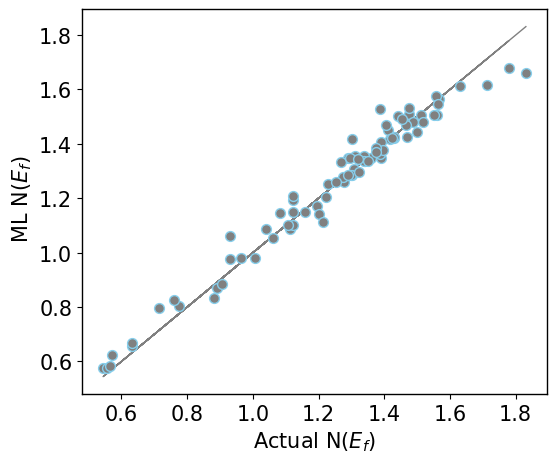

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(y_test, y_pred, marker='o', c= 'grey', s=50, edgecolor='skyblue')
plt.plot( y_test, y_test, zorder=0, lw=1, c='grey', )
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel(r' ML N($E_f$)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)

plt.show()


In [44]:
import numpy as np

# Input data for a single sample
sample = [-0.4250, 5.00, 2446.0, 1.6120, 10.958644, 0.0, 0.0, 5.0, 40.0, 15.0, 35.0, 5.0, 0.0, 0.0]

# Reshape the input into a 2D array
sample_reshaped = np.array(sample).reshape(1, -1)

# Make prediction
prediction = final_model.predict(sample_reshaped)
print("Prediction:", prediction)


Prediction: [0.69859433]


C:\Users\dpant\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [45]:
rom_dos_test = df.loc[y_test.index, 'ROM_DOS']

In [46]:
r2 = r2_score(y_test, rom_dos_test)
mae = mean_absolute_error(y_test, rom_dos_test)
rmse = np.sqrt(root_mean_squared_error(y_test, rom_dos_test))
# Print the evaluation metrics
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R² Score: 0.6232
Test MAE: 0.1401
Test RMSE: 0.4180


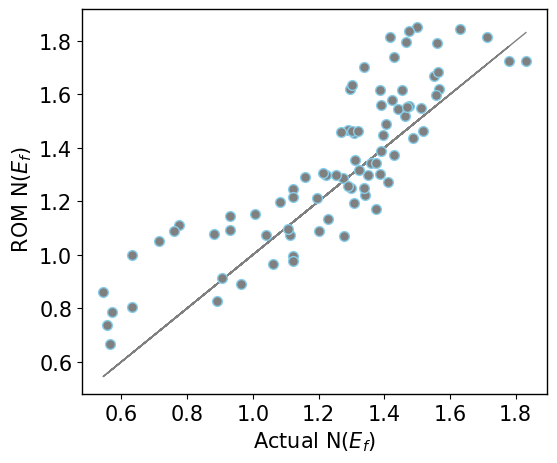

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(y_test, rom_dos_test, marker='o', c= 'grey', s=50, edgecolor='skyblue')
plt.plot( y_test, y_test, zorder=0, lw=1, c='grey', )
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel(r' ROM N($E_f$)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)

plt.show()


In [48]:
print(df.loc[y_test.index, 'Alloy'])

286        W5V40Nb15Ta35Ti5
282       W5Ta40Mo15Hf35Zr5
370     Mo30W10Ta40Cr10Ti10
177         W25Nb25Hf25Zr25
185          W25V25Ti25Zr25
               ...         
132         W10Ta30Ti40Zr20
13                 Nb50Ta50
362    Mo30Ta10Ti40Cr10Hf10
129         W10Nb30Ta40Hf20
112         Nb10Mo30W40Ti20
Name: Alloy, Length: 84, dtype: object


In [49]:
alloy_list = df.loc[y_test.index, 'Alloy'].tolist()
print(alloy_list)


['W5V40Nb15Ta35Ti5', 'W5Ta40Mo15Hf35Zr5', 'Mo30W10Ta40Cr10Ti10', 'W25Nb25Hf25Zr25', 'W25V25Ti25Zr25', 'W10V30Cr40Zr20', 'Zr30V10Nb40Ta10Hf10', 'Mo50Zr50', 'Nb5Ti40Zr15Mo35W5', 'Mo30W10V40Nb10Ti10', 'Cr33V33Ta34', 'Cr50Ti50', 'Mo50V10Hf30Zr10', 'Cr50V50', 'Mo50Ti50', 'Cr25Mo25W25Nb25', 'Nb5Ta40Mo15Ti35Hf5', 'Hf30Cr10Mo40W10Nb10', 'Mo30W10Nb40Ta10Hf10', 'Mo5W40V15Zr35Hf5', 'W30Ti10Hf40V10Nb10', 'W50Zr50', 'Nb20Hf20Zr20Mo20W20', 'Mo20Zr20Cr20W20Ta20', 'Mo5W40Ta15Cr35Ti5', 'Ta50Zr50', 'Cr20Hf20Mo20W20Ta20', 'W25Cr25Mo25Zr25', 'V22Nb50Zr28', 'Hf25Ta25Mo25W25', 'Cr22Ta50Ti28', 'Cr33W33Hf34', 'W20V20Nb20Ta20Ti20', 'Zr30W10Ta40Ti10Hf10', 'W30Ta10Ti40Mo10Hf10', 'V30Nb10Ta40Mo10Zr10', 'Nb33Zr33Hf34', 'Mo20W20V20Nb20Ti20', 'V20Ta20W20Ti20Hf20', 'Cr30Hf10Mo40W10Ta10', 'Nb5Cr40Mo15W35Ti5', 'Nb30Cr10Mo40W10Ti10', 'W5V40Ti15Hf35Zr5', 'Cr50Mo10V30Hf10', 'Mo33Ti33Hf34', 'Nb22Mo50Ta28', 'Mo5W40Nb15Ti35Hf5', 'V25Nb25Ti25Cr25', 'Nb20Ta20W20Ti20Zr20', 'Cr5Hf40Mo15W35Ta5', 'V25Ti25Hf25W25', 'Hf20V20Nb20Ta20

In [50]:
df_test = pd.concat([x_test, y_test], axis=1)
df_test.head()


,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf,N(Ef)
286,-1.70,5.00,2446.0,1.6120,10.958644,0.0,0.0,5.0,40.0,15.0,35.0,5.0,0.0,0.0,1.8312
282,-1.37,4.80,2645.5,1.5635,10.958644,0.0,15.0,5.0,0.0,0.0,40.0,0.0,5.0,35.0,1.3070
370,-5.44,5.40,2693.4,1.8040,11.793273,10.0,30.0,10.0,0.0,0.0,40.0,10.0,0.0,0.0,1.0401
177,-3.75,4.75,2496.0,1.6475,11.525651,0.0,0.0,25.0,0.0,25.0,0.0,0.0,25.0,25.0,1.2904
185,-5.50,4.75,2213.0,1.7150,11.525651,0.0,0.0,25.0,25.0,0.0,0.0,25.0,25.0,0.0,1.4639


# Code to create input for new alloy input and predict DOS

In [51]:
import re
import numpy as np
import pandas as pd

# Initialize an empty DataFrame
alloy_df = pd.DataFrame()

# Input alloy composition
while True:
    composition = input("Enter refractory alloy and the % of elements.\n"
                        "For example: Cr25Mo15Nb20Ta20W20 (Total % = 25+15+20+20+20 = 100)\n"
                        "Note: Sum of % should be between 99% and 101%.\n")

    try:
        # Extract elements and percentages using regex
        matches = re.findall(r'([A-Z][a-z]*)(\d*\.?\d+|\d+)', composition)
        elements = [element for element, _ in matches]
        percentages = [float(percentage) for _, percentage in matches]

        # Calculate total percentage
        total_percentage = sum(percentages)

        # Check if total percentage is within the allowed range [99%, 101%]
        if not (99 <= total_percentage <= 101):
            raise ValueError(
                f"The total atomic percentage for {composition} is {total_percentage}%, "
                "which is outside the allowed range [99%, 101%]. Please check your input."
            )

        # Populate the DataFrame
        alloy_df['Alloy'] = [composition]

        # Break the loop if the input is valid
        break

    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"Unexpected error: {e}")

# Calculate properties
try:
    # Mixing enthalpy
    alloy_df['Mixing Enthalpy'] = alloy_df['Alloy'].apply(lambda x: calculate_mixing_enthalpy(x, AB_mix_enthalpy))
    # VEC
    alloy_df['VEC'] = alloy_df['Alloy'].apply(lambda x: calculate_vec(x, pvec))
    # Melting temperature
    alloy_df['Melting Temperature'] = alloy_df['Alloy'].apply(lambda x: calculate_mt(x, mt))
    # Electronegativity
    alloy_df['Pauling Electronegativity'] = alloy_df['Alloy'].apply(lambda x: calculate_pauli(x, chi))
    # Entropy of mixing
    alloy_df['Entropy of Mixing'] = alloy_df['Alloy'].apply(calculate_entropy_of_mixing)

    # Add all 9 specified element columns
    all_elements = ['Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf']
    percentages_dict = {el: 0 for el in all_elements}  # Initialize all to 0

    # Update the dictionary with actual percentages from the alloy
    for el, percentage in matches:
        if el in percentages_dict:
            percentages_dict[el] = percentage

    # Add each element as a column in the DataFrame
    for el in all_elements:
        alloy_df[el] = percentages_dict.get(el, 0)

    # Make predictions
    X_new = alloy_df.drop(columns=['Alloy'])
    X_new_normalized = scaler.transform(X_new)
    X_new_normalized = pd.DataFrame(X_new_normalized, columns=scaler.feature_names_in_)
    pred = final_model.predict(X_new_normalized)

    # Add predictions to the DataFrame
    alloy_df['N(Ef)'] = pred
    alloy_df['rec_DOSperAtom'] = pred

    print('DOS at Fermi is:', pred)

    # Display the final DataFrame
    # print("\nFinal DataFrame with Predictions:")
    # print(alloy_df)

except Exception as e:
    print(f"An error occurred during calculations: {e}")

Enter refractory alloy and the % of elements.
For example: Cr25Mo15Nb20Ta20W20 (Total % = 25+15+20+20+20 = 100)
Note: Sum of % should be between 99% and 101%.
 Cr25Mo15Nb20Ta20W20


DOS at Fermi is: [0.76456796]


In [52]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train)

# Compute SHAP values for the training data
shap_values = explainer(X_train)


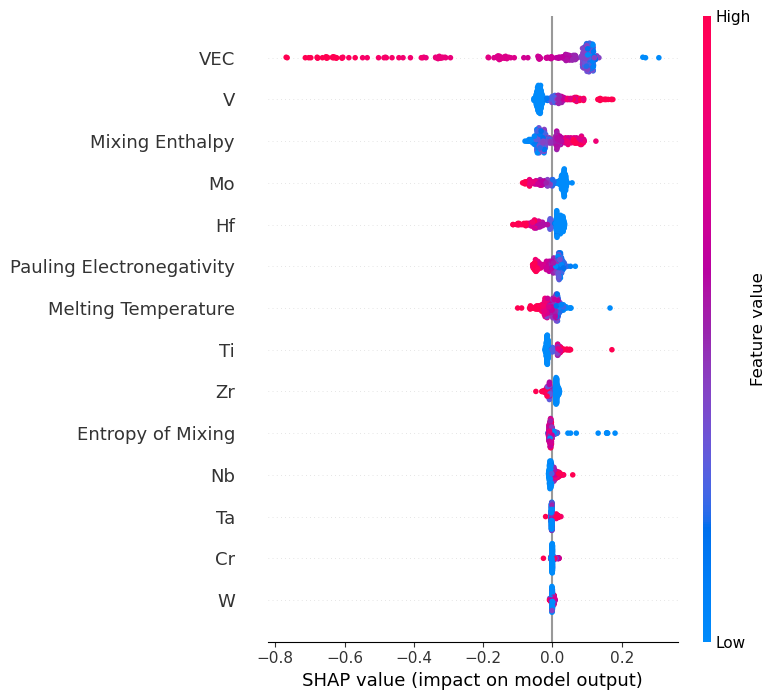

In [53]:
# Summary plot: Shows feature importance and direction of impact
shap.summary_plot(shap_values, X_train)


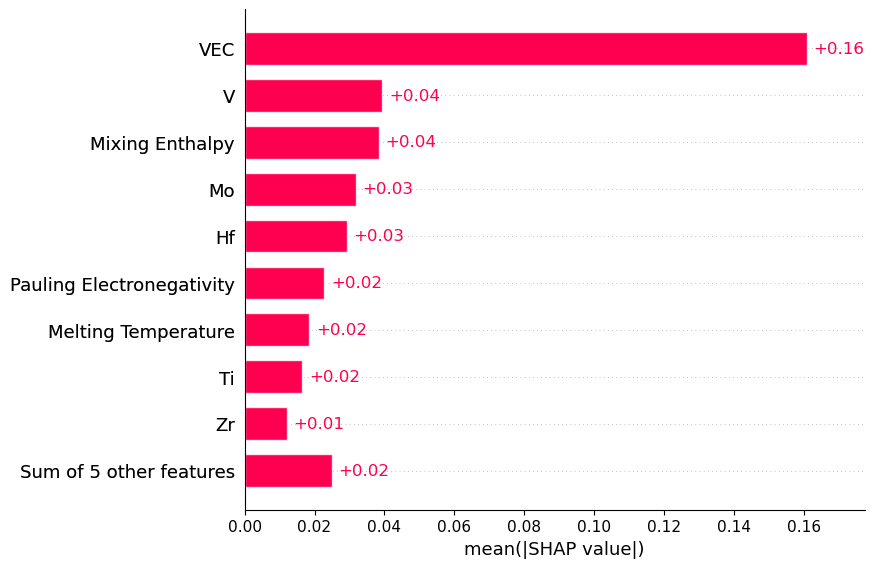

In [54]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

# SHAP Summary Plot (Global Feature Importance)
# shap.summary_plot(shap_values, X_train)

# SHAP Dependence Plot (Feature Interactions)
# shap.dependence_plot(3, shap_values.values, X_train)  # Fix applied here

# SHAP Feature Importance Bar Chart
shap.plots.bar(shap_values)


In [55]:
import pickle
with open('Final_ML_DOS.pkl', 'wb') as file:
    pickle.dump(final_model, file)